## Import spectrometer files to see temperature

In [1]:
# Let's load some basic packages...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# This makes the plots appear inside the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = 7, 5

from PIL import Image

from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy.optimize import newton
from scipy.optimize import least_squares
from scipy.signal import lfilter
from scipy.signal import filtfilt

%===========================

## Define basic functions

In [2]:
# Wavelength range
lba = np.linspace(200, 899, num=1000)*1e-9
lbnm = lba/1e-9

# Import spectrometer files
#==============
def impspec(filename):
    '''Function to import regular spectrometer files'''
    Int = pd.read_csv(filename, skiprows=[0,1,2,3,4,5,6,7,8,9,10,11,12,13], sep="\t", header=None, names=["lam","I"])
    Int = Int.drop(labels=[1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206], axis=0) #remove hot pixels
    # make a function of the spectrometer data
    lam = Int['lam']
    intensity = Int['I']
    fxnI = interp1d(lam,intensity)
    fxnF = fxnI(lbnm)
    fxnF_n = fxnF/np.max(fxnF)
    #fxnF_n = fxnF/np.average(fxnF[970::])
    return fxnF_n

# Import spectrometer files
#==============
def im2spec(filename):
    '''Convert image to spectrometer files nominally between 200 and 900 nm'''
    # Open the image file
    im = Image.open(filename).convert("L")
    display(im)
    # Get the pixel data in a 2D array
    pixels = np.array(im)
    # Sum the pixel values in each column
    col_sums = np.sum(pixels, axis=0)
    # Creat x-data arbitrarily set to 200 to 900nm to get in right range
    xdat = np.linspace(200, 900, len(col_sums))
    # make a function of the spectrometer data
    fxnI = interp1d(xdat,col_sums)
    fxnF = fxnI(lbnm)
    fxnF_n = fxnF/np.max(fxnF)
    #fxnF_n = fxnF/np.average(fxnF[970::])
    return fxnF_n

# define a normalized Planck's law fxn dependent on wavelength and temperature
#==============
def Plnknorm(lba,T):
    # constants
    h = 6.626e-34 # Planck's constant [m^2kg/s]
    c = 3e8 # Speed of light [m/s]
    kb = 1.381e-23 # Boltzman constant [m^2kg/s^2K]
    #
    Iact = 2*h*c**2 /(lba**5) * 1/(np.exp(h*c/(lba*kb*T)) - 1)
    Inorm = Iact/np.amax(Iact)
    return Inorm
#==============

# Use the desired cal curve calculate temps:
#==============
def E_est(Fxn,Gavg):
    corr = Gavg*Fxn
    #filter data
    n = 10 # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    yy = filtfilt(b,a,corr)
    Eest = yy/np.average(yy[995::])
    # Now do a least sqrs fit
    def lsqrfun(Tguess):
        return Plnknorm(lba, Tguess) - Eest

    T0 = 2000 # initial temperature guess
    rslt = least_squares(lsqrfun, T0)
    Tst = rslt.x
    return Eest,Tst
#==============

# Bring in Temp file from spectrometer

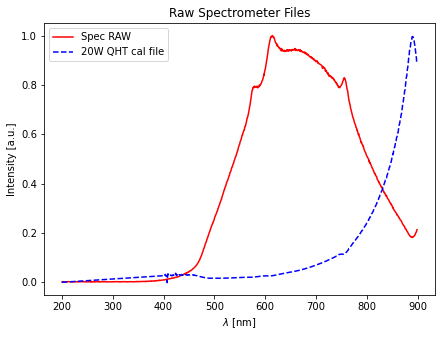

In [3]:
# Import spectrometer files and make normalized intensity array
Fspec = impspec('JAZA31041_14-59-40_pwr3.txt') 

# Pull in 20W QHT cal Gavg data and make a fxn to use here
#===============
# First read the graph-grabbed data from *.csv file
Gavg_20W = pd.read_csv("Gavg_20W.csv")
# make Gavg fxn
lam1 = Gavg_20W['lam']
Gavg20W = Gavg_20W['Gavg']
Gfxn = interp1d(lam1,Gavg20W)
G20 = Gfxn(lba)
#===============

#==============
# Plotting the raw data
fig, ax = plt.subplots()
ax.plot(lbnm,Fspec,'r')
ax.plot(lbnm,G20,'b--')
#
# Plot specifics
ax.set_xlabel('$\lambda$ [nm]')
ax.set_ylabel('Intensity [a.u.]')
#ax.set_yscale('log')
ax.legend(['Spec RAW','20W QHT cal file'])
plt.title('Raw Spectrometer Files')
plt.show()

# Calculate Temp based on calibration file

Tcalc using 20W curve =  1945.0 K


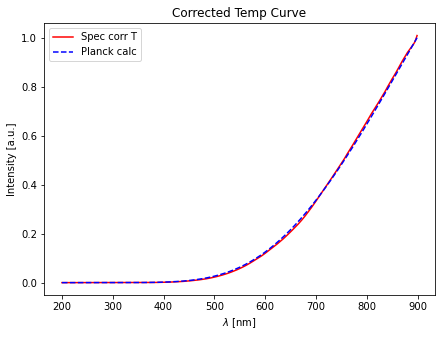

In [4]:
# Calc T with 20W curve
Espec, Tspec = E_est(Fspec,G20)
Tclc = Plnknorm(lba,Tspec)
Tlvl = Plnknorm(lba,2067) # Change to match Temp from cal sheet

print("Tcalc using 20W curve =  %1.1f K" % Tspec)

#==============
# Plotting the data
fig, ax = plt.subplots()
ax.plot(lbnm,Espec,'r')
ax.plot(lbnm,Tclc,'b--')
ax.plot(lbnm,Tlvl,'g-.')
#
# Plot specifics
ax.set_xlabel('$\lambda$ [nm]')
ax.set_ylabel('Intensity [a.u.]')
#ax.set_yscale('log')
ax.legend(['Spec corr T','smoothed','Cal T'])
plt.title('Corrected Temp Curve')
plt.show()
#==============